In [1]:
from os.path import join as pjoin
from os.path import abspath, pardir
import os
import glob
import sys
from nilearn.masking import intersect_masks, unmask
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
# path to where the bids dataset is stored
bidsroot = '/path/to/raw/fmri/bids/dataset'
# assumes that preprocessed data (fmriprep) and single trial estimates are stored in the derivatives subfolder
fmriprepdir = pjoin(bidsroot, 'derivatives', 'fmriprep')
betas_derivname = 'betas_loo/on_residuals/scalematched'
# define a path where the output is stored
out_basedir = pjoin(bidsroot, 'derivatives', 'animacysize')

In [2]:
# additional imports from this repository
sys.path.append(pjoin(os.path.pardir(), 'src'))
from betas import load_betas, load_filenames, filter_catch_trials, average_betas_per_concept
from utils import pearsonr_nd, load_animacy_size

/home/ocontier/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


220411-13:31:31,47 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.5.1


In [3]:
# define the subject of interest and output directory for this subject
sub = '01'
outdir = pjoin(out_basedir, f'sub-{sub}')
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Load brain data

In [5]:
# get brain mask
bmask = pjoin(bidsroot, 'derivatives', 'brainmasks', f'sub-{sub}_space-T1w_brainmask.nii.gz')

In [6]:
# load betas
smooth = 3.
betas = load_betas(sub, bmask, betas_derivname=betas_derivname, smoothing=smooth)
filenames = load_filenames(sub, bidsroot, betas_derivname)

loading betas: 100%|█████████████████████████████████████████████████████| 120/120 [00:00<00:00, 85264.52it/s]
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty fou

In [7]:
# filter catch trials
betas, filenames, noncatch_is = filter_catch_trials(betas, filenames)

In [8]:
# average betas within concept
concepts = np.array([
    fn.split('/')[1][:-8]
    for fn in filenames
])
unique_concepts = np.unique(concepts)

betas_concept = []
for c in tqdm(unique_concepts):
    inds = np.where(concepts == c)
    betas_concept.append(betas[inds].mean(axis=0))
betas_concept = np.stack(betas_concept)

  0%|          | 0/720 [00:00<?, ?it/s]

In [9]:
# double check that arrays have correct shape
betas_concept.shape, unique_concepts.shape

((720, 189164), (720,))

# Load animacy and size

In [10]:
# load animacy and size ratings for entire THINGS object concept database
anisize_df = load_animacy_size()

In [11]:
# select values for fmri stimuli
data_df = pd.concat([
    anisize_df.loc[anisize_df.uniqueID == con,]
    for con in unique_concepts
])
print(data_df.shape)

(720, 3)


In [12]:
# show the regressor correlation
r = np.corrcoef(anisize_df.animacy.to_numpy(), anisize_df['size'].to_numpy())[0,1]
print(f'r(animacy, size) = {r:.3f} (across all objects)')
r = np.corrcoef(data_df.animacy.to_numpy(), data_df['size'].to_numpy())[0,1]
print(f'r(animacy, size) = {r:.3f} (across objects presented in fmri)')

r(animacy, size) = -0.094 (across all objects)
r(animacy, size) = -0.073 (across objects presented in fmri)


In [15]:
# show biggest and smallest objects as examples
data_df.sort_values('size')

,uniqueID,animacy,size
1236,powder,1.6842,112.428571
1150,pepper1,2.4118,113.800000
1309,rice,3.8205,115.413043
24,ant,6.9444,116.011111
1020,mosquito,6.8421,117.765957
...,...,...,...
10,airplane,1.2368,410.468085
1698,train,1.4000,414.085106
9,aircraft_carrier,1.2778,421.329545
1501,space_shuttle,1.3684,421.844444


In [14]:
# normalize regressors
for regname in ['animacy', 'size']:
    data_df[regname] -= data_df[regname].mean()
    data_df[regname] /= data_df[regname].std()
X = data_df.to_numpy()

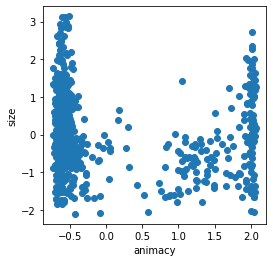

In [16]:
# inspect range/distribution of normalized regressors
fig = plt.figure(figsize=(4,4))
plt.scatter(X['animacy'], X['size'])
plt.xlabel('animacy');plt.ylabel('size')
plt.show()

# Fit regression

In [ ]:
# fit a simple linear regression
n_jobs = 10
lr = LinearRegression(
    n_jobs=n_jobs, normalize=False, fit_intercept=True, 
)
lr.fit(X, betas_concept)

In [17]:
# save regression weights for animacy and size to nifti files
for i, regname in enumerate(X.columns):
    img = unmask(lr.coef_[:,i], umask)
    img.to_filename(pjoin(outdir, f'sub-{sub}_{regname}_beta_smooth-{int(smooth)}.nii.gz'))